E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
g = torch.Generator(device='cpu').manual_seed(2147483647)

In [121]:
class CFG:
    SEED = 42
    CONTEXT_LEN = 3

    VOCAB_SIZE = 27 # 26 letters + 1 for padding
    EMBED_DIMS = 10
    HIDDEN_DIMS = 300
    HIDDEN_DIMS2 = [300, 200, 100]

    BATCH_SIZE  = 128
    BATCH_SIZE2 = 256
    EPOCHS  =  1000
    EPOCHS2 = 20000
    LEARNING_RATE = 0.001

In [122]:
words = open('names.txt').read().splitlines()

In [123]:
stoi = {s:i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [124]:
def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * CFG.CONTEXT_LEN
        chrs = list(w) + ['.']
        for c in chrs:
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, ytr = build_dataset(words[:n1])
Xv, yv = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])
# Train dataset is used to train the parameters, val is used to tune hyperparameters, and test is used to evaluate the final model.

In [125]:
Xtr.shape # torch.Size([N, CONTEXT_LEN])
ytr.shape # torch.Size([N])

torch.Size([182467])

$$ y_\text{logits} = Wx_\text{cat} + b + U\tanh(Hx_\text{cat} + d) $$
where $ x_\text{cat} $ is `C[X].view(xlen, -1)`

In [ ]:
# Initialise/reset parameters

xlen = CFG.CONTEXT_LEN*CFG.EMBED_DIMS # In the paper: (n-1)*m, where n-1 is the context length

C = torch.randn((27, CFG.EMBED_DIMS),              generator=g)
# C[5] ≡ F.one_hot(torch.tensor(5), num_classes=27).float() @ C. Former is faster.

H = torch.randn((CFG.HIDDEN_DIMS, xlen),           generator=g) * 0.1
d = torch.randn((CFG.HIDDEN_DIMS, 1),              generator=g) * 0.01 # not 0 ∵ tanh neuron

U = torch.randn((CFG.VOCAB_SIZE, CFG.HIDDEN_DIMS), generator=g) * 0.01
W = torch.randn((CFG.VOCAB_SIZE, xlen),            generator=g) * 0.01
b = torch.zeros((CFG.VOCAB_SIZE, 1))

params = [C, H, d, U, W, b]
for p in params:
    p.requires_grad = True

In [127]:
cat = C[Xtr].view(xlen, -1)
cat.shape

torch.Size([30, 182467])

In [128]:
sum(p.numel() for p in params) # Total number of parameters

18507

In [ ]:
def return_logits(Xb):
    cat = C[Xb].view(xlen, -1)  # Concatenate embeddings: N × (CONTEXT_LEN * EMBED_DIMS)
    h = H @ cat + d  # hidden layer preactivations
    
    logits = W @ cat + b + U @ torch.tanh(H @ cat + d)
    return logits.t()  # Return shape: N × VOCAB_SIZE

In [130]:
# Train
lossi = []
stepi = []

In [131]:
deci_epoch = CFG.EPOCHS // 10
for epoch in range(CFG.EPOCHS):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (CFG.BATCH_SIZE,), generator=g)
    Xb, yb = Xtr[ix], ytr[ix]
    
    # Forward pass
    logits = return_logits(Xb)
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None # Set gradients to zero before backward pass
    loss.backward() # Populate those gradients

    # Update parameters
    with torch.no_grad():
        lr = 0.1 if epoch < CFG.EPOCHS/2 else 0.01
        for p in params:
            p.data -= lr * p.grad
    
    # Track stats
    if epoch % deci_epoch == 0:
        print(f'Epoch {epoch}/{CFG.EPOCHS}, Loss: {loss.item()}')
    lossi.append(loss.item())
    stepi.append(epoch * (Xtr.shape[0] // CFG.BATCH_SIZE) + ix[0].item() // CFG.BATCH_SIZE)

Epoch 0/1000, Loss: 3.3048806190490723
Epoch 100/1000, Loss: 3.10200572013855
Epoch 200/1000, Loss: 2.960852861404419
Epoch 300/1000, Loss: 2.8839385509490967
Epoch 400/1000, Loss: 2.811224937438965
Epoch 500/1000, Loss: 2.9287168979644775
Epoch 600/1000, Loss: 2.930020570755005
Epoch 700/1000, Loss: 2.9517695903778076
Epoch 800/1000, Loss: 2.8303005695343018
Epoch 900/1000, Loss: 2.753793239593506


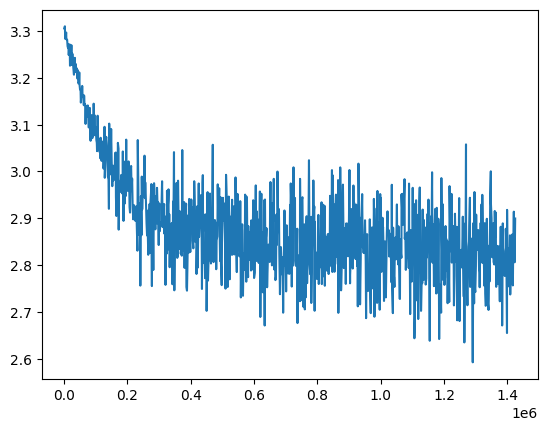

In [132]:
plt.plot(stepi, lossi)

In [133]:
@torch.no_grad()
def get_loss(X, y):
    logits = return_logits(Xb)
    return F.cross_entropy(logits, yb)

# Evaluate on validation and test sets
val_loss = get_loss(Xv, yv)
test_loss = get_loss(Xte, yte)
print(f'Validation Loss: {val_loss}, Test Loss: {test_loss}')

Validation Loss: 2.892993450164795, Test Loss: 2.892993450164795


In [134]:
# F.cross_entropy(logits, yb) is the same as:
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# loss = -probs[torch.arange(BATCH_SIZE), yb].log().mean()
# Both will give the same result, but F.cross_entropy is more numerically stable and faster obv

In [135]:
# Generate names
NUM_NAMES = 10
MAX_LENGTH = 20

names = []

for name in range(NUM_NAMES):
    context = [0] * CFG.CONTEXT_LEN  # Start with the context of all dots
    name = []
    
    for _ in range(MAX_LENGTH):
        logits = return_logits(torch.tensor([context], dtype=torch.long))

        probs = F.softmax(logits, dim=-1).squeeze(1)

        next_char_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_char_idx == 0: break # Stop if we hit the end character (dot)
        
        name.append(itos[next_char_idx])
        context = context[1:] + [next_char_idx]  # Update context
    
    names.append(''.join(name))

print(names)

['seh', 'adpsnandbnao', 'ii', 'aaillyaesi', 'efe', 'ameuiiom', 'ds', 'oaeeef', 'niniqiiotz', 'ygeq']


# 2-layer model

In [136]:
class BengioLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()

        self.linear_path = nn.Linear(input_dim, output_dim)      # Wx + b
        self.tanh_path = nn.Sequential(
            nn.Linear(input_dim, hidden_dims),                   # Hx + d
            nn.Tanh(),                                           # h
            nn.Linear(hidden_dims, output_dim, bias=False)       # U
        )
    def forward(self, x):
        linear_out = self.linear_path(x)
        tanh_out = self.tanh_path(x)
        return linear_out + tanh_out

class BengioModel(nn.Module):
    def __init__(self, vocab_size, embed_dims, context_len, hidden_dims):
        super().__init__()
        self.C = nn.Embedding(vocab_size, embed_dims)

        self.model = nn.Sequential(
            BengioLayer(context_len * embed_dims, hidden_dims[1], hidden_dims[0]),
            BengioLayer(hidden_dims[1], vocab_size, hidden_dims[2]),
        )

    def forward(self, X):
        cat = self.C(X).view(X.shape[0], -1) # Take embeddings and concatenate them
        return self.model(cat)

In [137]:
model = BengioModel(vocab_size=CFG.VOCAB_SIZE, embed_dims=CFG.EMBED_DIMS, context_len=CFG.CONTEXT_LEN, hidden_dims=CFG.HIDDEN_DIMS2)
deci_epoch = CFG.EPOCHS2 // 10
for epoch in range(CFG.EPOCHS2):
    ix = torch.randint(0, Xtr.shape[0], (CFG.BATCH_SIZE2,), generator=g)
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, yb)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        lr = 0.1 if epoch < CFG.EPOCHS2/2 else 0.01
        for p in model.parameters():
            p.data -= lr * p.grad

    if epoch % deci_epoch == 0:
        print(f'Epoch {epoch}/{CFG.EPOCHS2}, Loss: {loss.item()}')

Epoch 0/20000, Loss: 3.3245608806610107
Epoch 2000/20000, Loss: 2.3180062770843506
Epoch 4000/20000, Loss: 2.2498598098754883
Epoch 6000/20000, Loss: 2.179196834564209
Epoch 8000/20000, Loss: 2.2625465393066406
Epoch 10000/20000, Loss: 2.1029839515686035
Epoch 12000/20000, Loss: 1.9912012815475464
Epoch 14000/20000, Loss: 2.140272617340088
Epoch 16000/20000, Loss: 2.1168465614318848
Epoch 18000/20000, Loss: 2.1301429271698


In [138]:
@torch.no_grad()
def get_loss(model, X, y):
    logits = model(X)
    loss = F.cross_entropy(logits, y)
    return loss.item()

# Evaluate on validation and test sets
val_loss = get_loss(model, Xv, yv)
test_loss = get_loss(model, Xte, yte)
print(f'Validation Loss: {val_loss}, Test Loss: {test_loss}')

Validation Loss: 2.1397833824157715, Test Loss: 2.147035837173462


In [139]:
# Generate names
NUM_NAMES = 10
MAX_LENGTH = 20

names = []

for name in range(NUM_NAMES):
    context = [0] * CFG.CONTEXT_LEN  # Start with the context of all dots
    name = []
    
    for _ in range(MAX_LENGTH):
        logits = model(torch.tensor([context], dtype=torch.long))

        probs = F.softmax(logits, dim=-1).squeeze(1)

        next_char_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_char_idx == 0: break # Stop if we hit the end character (dot)
        
        name.append(itos[next_char_idx])
        context = context[1:] + [next_char_idx]  # Update context
    
    names.append(''.join(name))

print(names)

['ace', 'mirus', 'ashakilsiyah', 'laie', 'nayasymond', 'dem', 'leahlandrick', 'julian', 'acereksam', 'auf']
